# Machine Learning Basics: Predicting Kubernetes Incidents - Part 2

## Introduction

Welcome to the third notebook in our series on AI for Kubernetes operations! In this notebook, we will scale the concepts introduced in the previous notebooks to a **real-world Kubernetes operational dataset**. By applying advanced machine learning models, we aim to predict Kubernetes incidents and operational metrics with high accuracy.

### Objectives

By the end of this notebook, you will:
1. Apply machine learning models to predict:
   - **Incident Types** (`Normal`, `Warning`, `Error`) using classification techniques.
   - **Resource Efficiency** (a continuous variable) using regression techniques.
2. Learn how to preprocess and scale a real-world dataset for machine learning.
3. Evaluate and interpret model performance using metrics like:
   - Accuracy
   - Mean Absolute Error (MAE)
   - R² Score
   - Confusion Matrices
   - Feature Importance
4. Use visualizations to understand and validate model predictions.

### Key Features:
- Learn how to preprocess and scale real-world datasets for machine learning.
- Train and evaluate multiple models for classification and regression tasks.
- Interpret model results using visualizations and feature importance analysis.

## 1. Load and Explore Dataset

Before we dive into modeling, let’s load the **preprocessed Kubernetes dataset** from the previous notebook. This dataset includes operational metrics and incident labels, already cleaned and ready for machine learning tasks.

### Installing Required Libraries

Ensure all the necessary libraries are installed. Run the following command to install them:

In [159]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


### Loading the Dataset

In [160]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/preprocessed_kubernetes_data.csv")

# Display the first few rows to understand the structure
df.head()

,timestamp,pod_name,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,...,namespace_kube-system,namespace_prod,event_type_Error,event_type_Normal,event_type_Warning,event_message_Completed,event_message_Failed,event_message_Killed,event_message_OOMKilled,event_message_Started
0,2023-01-01 00:00:00,pod_0,0.038162,0.949259,9.993579,13.722542,77.619073,93.177619,37.900532,0,...,False,False,False,False,True,False,False,True,False,False
1,2023-01-01 00:00:00,pod_1,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,1,...,False,False,True,False,False,False,True,False,False,False
2,2023-01-01 00:00:00,pod_2,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,1,...,True,False,False,True,False,True,False,False,False,False
3,2023-01-01 00:00:00,pod_3,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,1,...,False,False,False,False,True,False,False,False,True,False
4,2023-01-01 00:00:00,pod_4,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,0,...,False,True,True,False,False,False,False,True,False,False


### Exploring the Dataset

Let’s examine the dataset to understand its features and structure:

In [161]:
# Get a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     15000 non-null  object 
 1   pod_name                      15000 non-null  object 
 2   cpu_allocation_efficiency     15000 non-null  float64
 3   memory_allocation_efficiency  15000 non-null  float64
 4   disk_io                       15000 non-null  float64
 5   network_latency               15000 non-null  float64
 6   node_temperature              15000 non-null  float64
 7   node_cpu_usage                15000 non-null  float64
 8   node_memory_usage             15000 non-null  float64
 9   scaling_event                 15000 non-null  int64  
 10  pod_lifetime_seconds          15000 non-null  int64  
 11  hour                          15000 non-null  int64  
 12  day_of_week                   15000 non-null  int64  
 13  r

#### What to Look For:

- **Column Types**:
  - Are the features numerical, categorical, or boolean?
- **Missing Data**:
  - Are there any missing values in the dataset?
- **Feature Overview**:
  - What metrics (e.g., `cpu_allocation_efficiency`, `network_latency`) and targets (`event_type`) are included?


### Boolean Columns

Some features in the dataset are boolean (True/False). Let’s analyze their distributions:

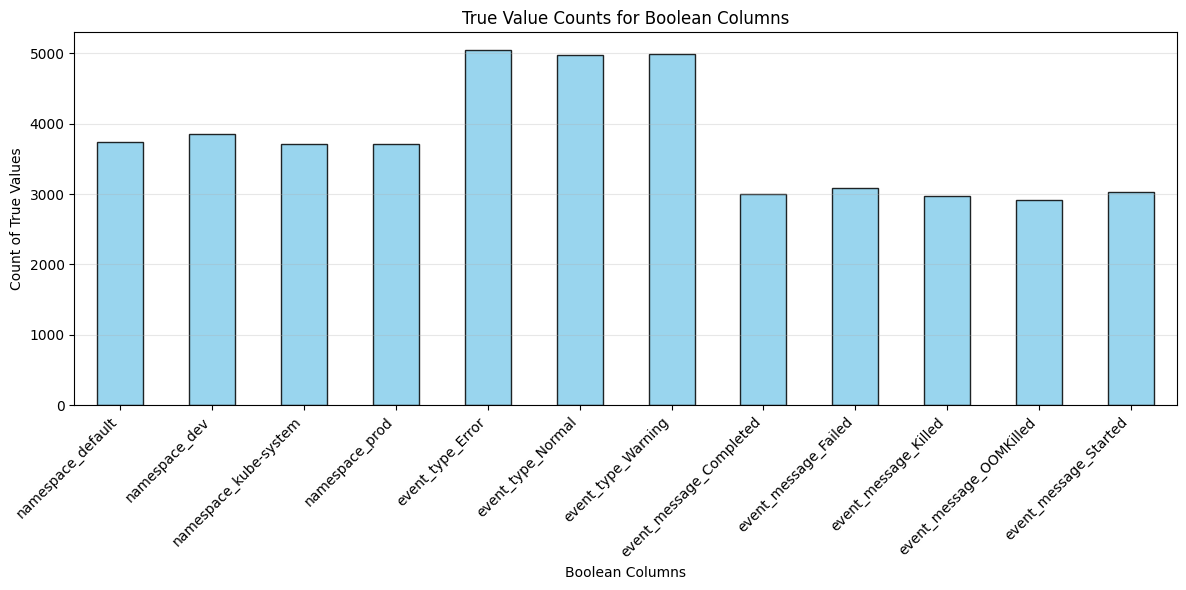

In [162]:
# Identify boolean columns
bool_columns = df.select_dtypes(include=["bool"]).columns

# Count True values for each boolean column
true_counts = df[bool_columns].sum()

# Plot side-by-side bar chart
plt.figure(figsize=(12, 6))
true_counts.plot(kind="bar", color="skyblue", edgecolor="black", alpha=0.85)
plt.title("True Value Counts for Boolean Columns")
plt.xlabel("Boolean Columns")
plt.ylabel("Count of True Values")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Dataset Insights

- The dataset is structured with both numerical and boolean features.
- Boolean columns (e.g., `namespace_*`, `event_type_*`) represent operational events or categorical labels.
- Numerical features like `cpu_allocation_efficiency` and `network_latency` capture system behavior.

## 2. Preprocessing and Scaling

Preprocessing the dataset ensures that our machine learning models perform optimally. One crucial step is **scaling numerical features** to standardize their ranges, which avoids dominance of features with larger scales and enhances numerical stability during calculations.

### Why Scale the Data?
- **Improves Model Performance**: Many machine learning algorithms, including Linear Regression, assume normalized feature ranges.
- **Prepares for Multi-Model Workflows**: Consistent scaling allows the same dataset to be used across various algorithms.

We will use `StandardScaler` from `scikit-learn` to standardize all numerical features.


### Scaling Numerical Features

In [163]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features to scale
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
    "resource_efficiency",
    "io_latency_ratio",
]

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows of the scaled dataset
df.head()

,timestamp,pod_name,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,...,namespace_kube-system,namespace_prod,event_type_Error,event_type_Normal,event_type_Warning,event_message_Completed,event_message_Failed,event_message_Killed,event_message_OOMKilled,event_message_Started
0,2023-01-01 00:00:00,pod_0,-1.605400,1.545132,-1.701373,-1.486163,0.758554,1.521766,-0.423752,0,...,False,False,False,False,True,False,False,True,False,False
1,2023-01-01 00:00:00,pod_1,-0.000279,-1.562708,1.515888,-0.765061,1.042534,0.418837,-1.553428,1,...,False,False,True,False,False,False,True,False,False,False
2,2023-01-01 00:00:00,pod_2,0.853155,-0.186679,-0.595039,1.279161,-1.678500,0.223416,-1.099806,1,...,True,False,False,True,False,True,False,False,False,False
3,2023-01-01 00:00:00,pod_3,0.089690,1.272519,0.968575,-0.559600,1.079164,1.027941,1.536165,1,...,False,False,False,False,True,False,False,False,True,False
4,2023-01-01 00:00:00,pod_4,-0.261974,1.324995,0.735337,-0.139608,-1.338303,0.115638,0.712065,0,...,False,True,True,False,False,False,False,True,False,False


## 3. Applying Linear Regression

Linear Regression is one of the simplest machine learning models. It predicts a number (a continuous value) based on one or more input features. For example:
- Predicting **resource efficiency** based on metrics like CPU and memory usage.

### How Does It Work?
Linear Regression draws a straight line through the data to make predictions. It tries to find the best line that gets as close as possible to all the points in the dataset.

Think of it like this:
- If you plot CPU efficiency on the x-axis and resource efficiency on the y-axis, Linear Regression will find the straight line that predicts the y-values based on x-values.

The closer the line is to the actual points, the better the predictions.

![Linear Regression Example](https://upload.wikimedia.org/wikipedia/commons/3/3a/Linear_regression.svg)

*(Source: Wikipedia)*

### Objective

We’ll use Linear Regression to predict **`resource_efficiency`**, which measures the average efficiency of CPU and memory allocation.

### Steps to Apply Linear Regression

1. Define the features (`X`) and target variable (`y`).
2. Split the data into training and testing sets (70% training, 30% testing).
3. Train the Linear Regression model using the training data.
4. Evaluate the model’s performance using:
   - **Mean Absolute Error (MAE)**: Measures the average difference between predicted and actual values.
   - **R² Score**: Indicates how well the model explains the variability of the target variable.

### Training the Model

In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Define features and target
X = df[numerical_features]  # Input features
y = df["resource_efficiency"]  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

### Evaluating Model Performance

In [165]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.00
R² Score: 1.00


### Visualizing Predictions

A scatter plot helps us visualize how well the model’s predictions align with the actual values. The red dashed line represents **perfect predictions** (i.e., predicted = actual).

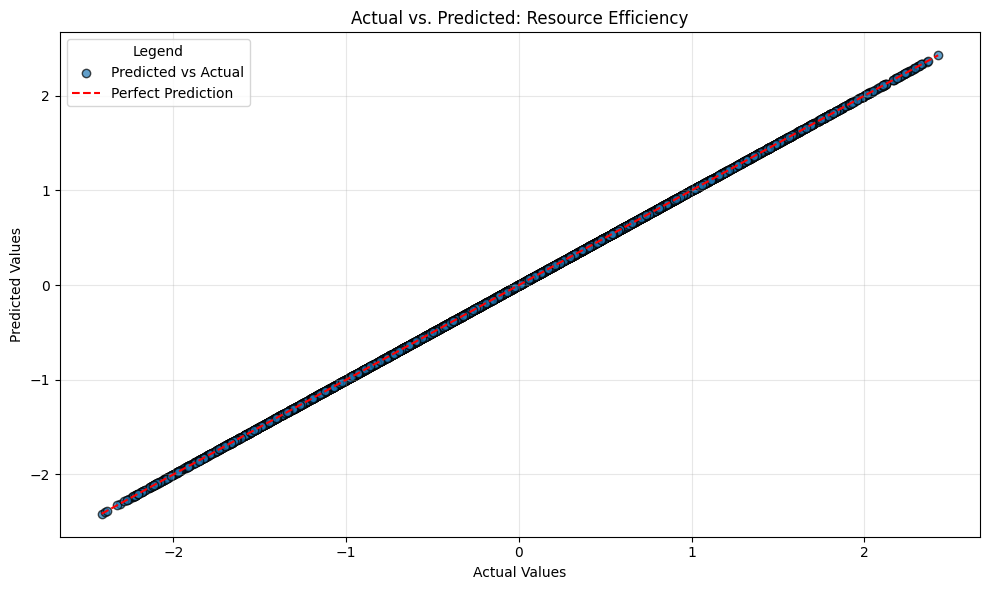

In [166]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k", label="Predicted vs Actual")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    label="Perfect Prediction",
)
plt.title("Actual vs. Predicted: Resource Efficiency")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend(title="Legend", loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Interpreting Results

1. **MAE**:
   - Indicates the average error in the model’s predictions.
   - Lower values mean better performance.
2. **R² Score**:
   - Measures how well the model explains the variability in `resource_efficiency`.
   - Values closer to 1 indicate a better fit.

## 4. Random Forest Classifier for Incident Prediction

Now, let’s move from predicting continuous values to predicting **incident types** (`Normal`, `Warning`, `Error`). For this, we’ll use a **Random Forest Classifier**, a powerful model that combines multiple decision trees to make accurate predictions.

### What is a Random Forest?

A **Random Forest** is an **ensemble learning method**:
1. It builds many decision trees, each trained on a random subset of the data.
2. It combines the predictions from all the trees to make the final decision (e.g., through majority voting for classification).

### Why Use Random Forest?
- **Handles Complexity**: Captures complex relationships in the data.
- **Prevents Overfitting**: Random sampling makes the model robust to noisy data.
- **Feature Importance**: Identifies which features are most important for predictions.

We will recreate the original **`event_type`** column, which indicates the type of incident (`Normal`, `Warning`, or `Error`). This will allow us to train a **multi-class Random Forest Classifier** to predict the incident type in a single model.

### Recreating the `event_type` Column

Let’s combine the encoded `event_type_*` columns back into a single categorical column:

In [167]:
# Recreate the event_type column
def map_event_type(row):
    if row["event_type_Normal"]:
        return "Normal"
    elif row["event_type_Warning"]:
        return "Warning"
    elif row["event_type_Error"]:
        return "Error"
    return None


# Apply the function row-wise to create the event_type column
df["event_type"] = df.apply(map_event_type, axis=1)

# Display the first few rows to confirm
df[["event_type_Normal", "event_type_Warning", "event_type_Error", "event_type"]].head()

,event_type_Normal,event_type_Warning,event_type_Error,event_type
0,False,True,False,Warning
1,False,False,True,Error
2,True,False,False,Normal
3,False,True,False,Warning
4,False,False,True,Error


### Objective
We’ll train a single **Random Forest Classifier** to predict the recreated `event_type` column, which has three classes:
- `Normal`
- `Warning`
- `Error`

### Steps to Train the Model

1. Define features (`X`) and target variable (`y`).
2. Split the data into training and testing sets.
3. Train a **Random Forest Classifier** for multi-class classification.
4. Evaluate performance using:
   - Accuracy
   - Classification Report
   - Confusion Matrix
5. Analyze feature importance.

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

# Define features and target
X = df[numerical_features]  # Input features
y = df["event_type"]  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.33

Classification Report:
              precision    recall  f1-score   support

       Error       0.34      0.46      0.39      1521
      Normal       0.33      0.22      0.26      1517
     Warning       0.32      0.31      0.32      1462

    accuracy                           0.33      4500
   macro avg       0.33      0.33      0.32      4500
weighted avg       0.33      0.33      0.32      4500



### Visualizing the Confusion Matrix

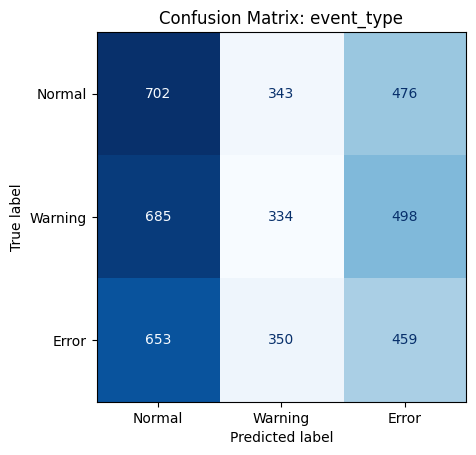

In [169]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=["Normal", "Warning", "Error"],
    cmap="Blues",
    colorbar=False,
)
plt.title("Confusion Matrix: event_type")
plt.show()

### Analyzing Feature Importance

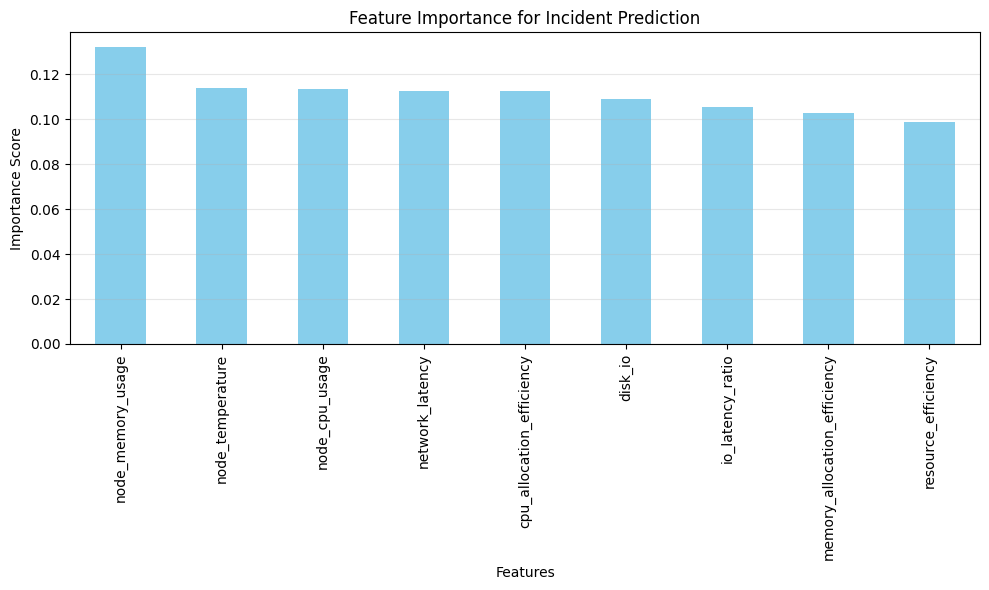

In [170]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Feature Importance for Incident Prediction")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### What Do These Results Tell Us?

1. **Model Accuracy**:
   - Shows how well the model predicts incident types overall.
   - A high accuracy indicates the model performs well on the dataset.

2. **Classification Report**:
   - Precision: How often the model correctly predicts a specific class.
   - Recall: How well the model identifies all instances of a class.
   - F1 Score: A balanced metric combining precision and recall.

3. **Feature Importance**:
   - Highlights which metrics (e.g., `cpu_allocation_efficiency`, `network_latency`) are most critical for predicting incidents.

## 5. Applying Linear Regression and Random Forest for Multiple Columns

Now that we’ve trained Linear Regression and Random Forest models for specific use cases, let’s generalize the process to predict **other columns** in the dataset. We’ll loop through the specified columns (`columns_to_compare`) and evaluate the performance of both models (Linear Regression for continuous targets, Random Forest for classification tasks).

For each target column in `columns_to_compare`, we will:
1. Train **Linear Regression** if the target is continuous.
2. Train a **Random Forest Classifier** if the target is categorical or binary.
3. Evaluate performance using:
   - **MAE** and **R² Score** for regression tasks.
   - **Accuracy**, **Confusion Matrix**, and **Classification Report** for classification tasks.

### 5.1. Applying Linear Regression for Multiple Columns

In this step, we’ll focus on using **Linear Regression** to predict multiple target columns in the dataset. For each column in `columns_to_compare`, we:

1. Treat the column as the target variable.
2. Train a **Linear Regression model** using the numerical features as inputs.
3. Evaluate the model’s performance using:
   - **R² Score**: Measures how well the model predicts the target. Higher scores are better.
   - **Scatter Plots**: Show how close the predicted values are to the actual values.

#### How to Read the Scatter Plots
- Points close to the red dashed line indicate accurate predictions.
- Points far from the red line suggest the model struggles with that target.

Let’s apply Linear Regression to each target and visualize the results!

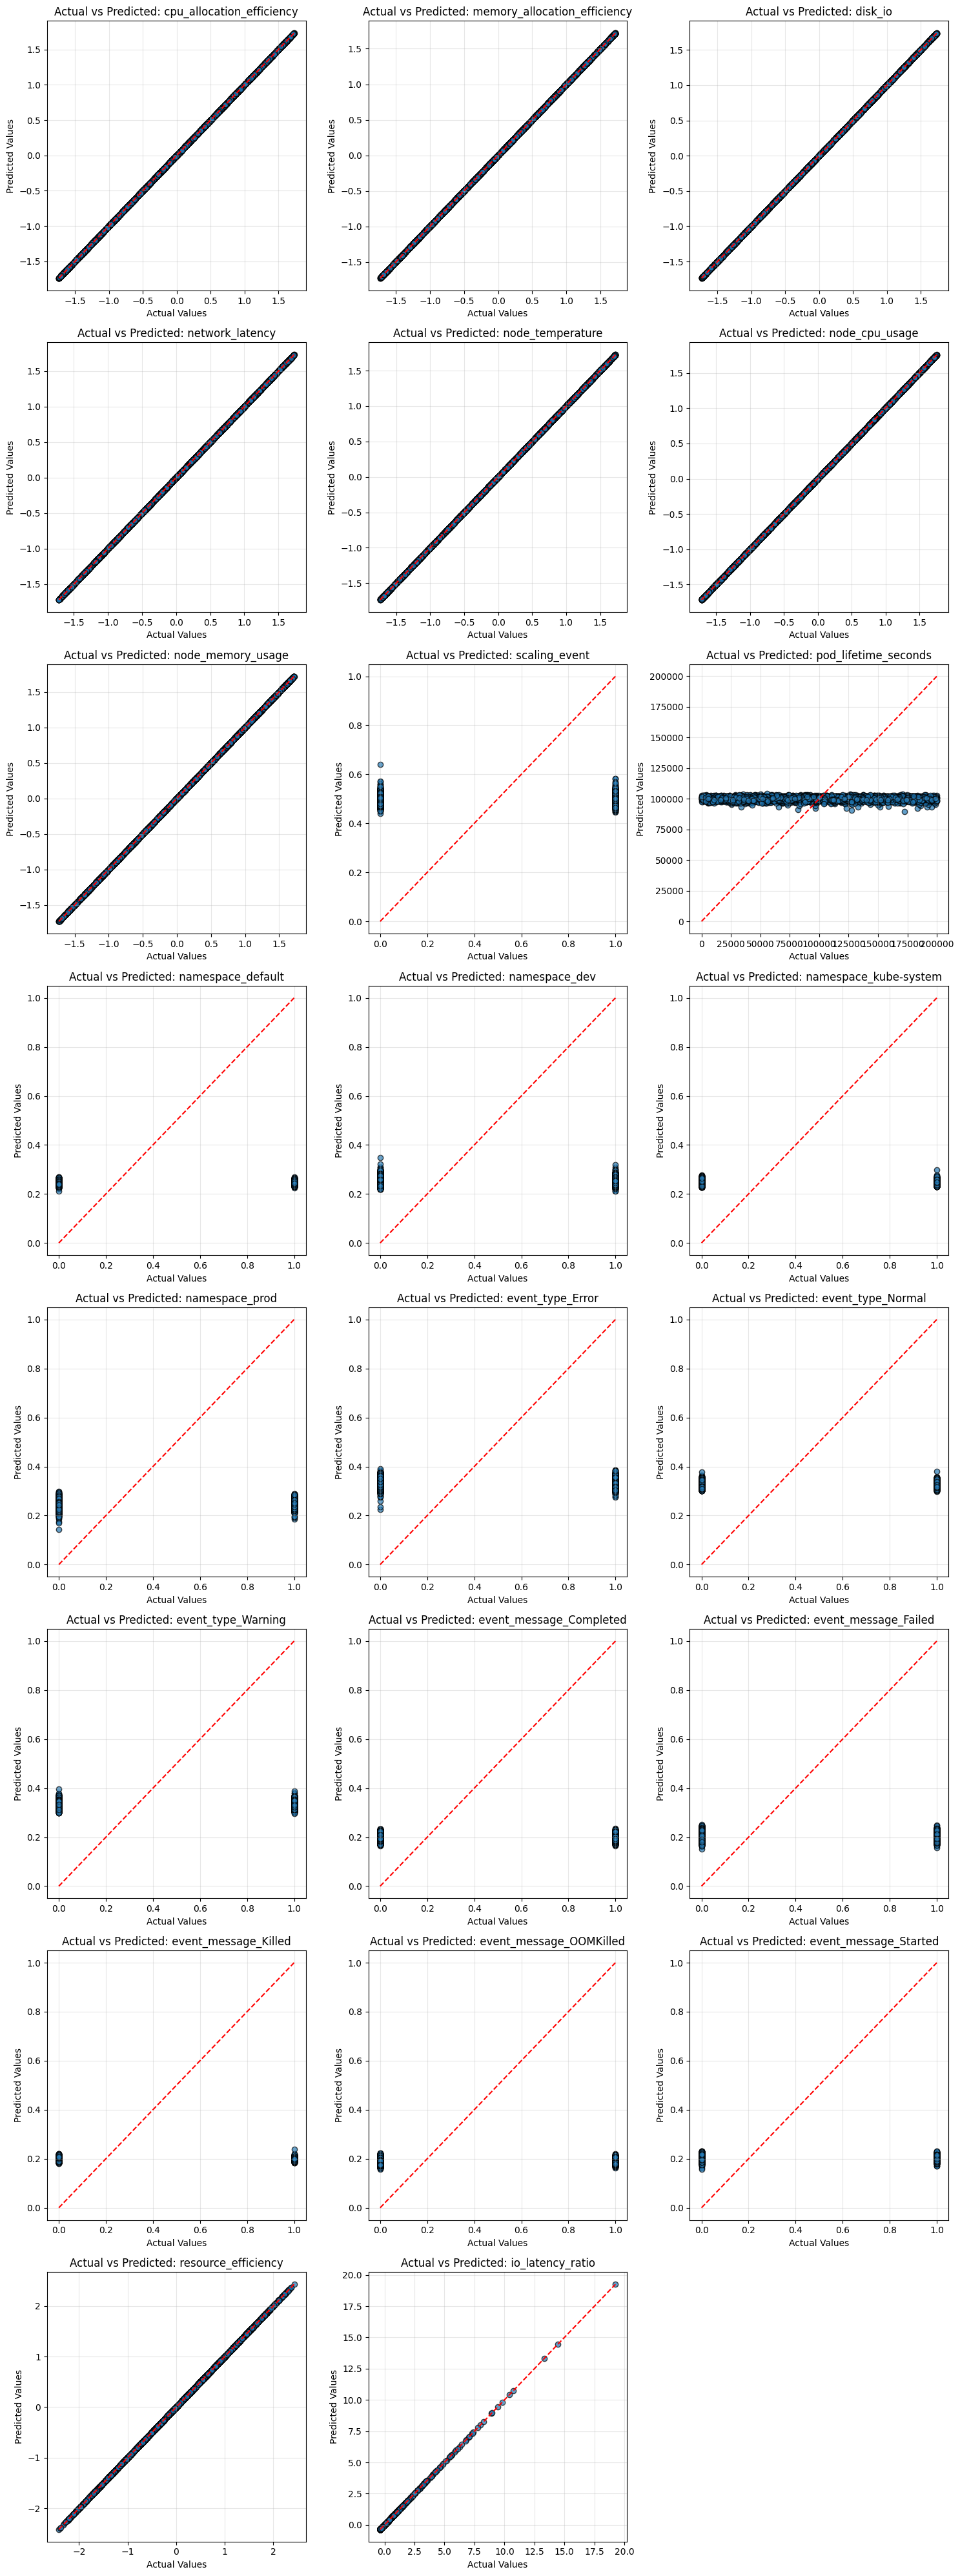

In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# List of features to include
columns_to_compare = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
    "scaling_event",
    "pod_lifetime_seconds",
    "namespace_default",
    "namespace_dev",
    "namespace_kube-system",
    "namespace_prod",
    "event_type_Error",
    "event_type_Normal",
    "event_type_Warning",
    "event_message_Completed",
    "event_message_Failed",
    "event_message_Killed",
    "event_message_OOMKilled",
    "event_message_Started",
    "resource_efficiency",
    "io_latency_ratio",
]

# Prepare subplots
n_cols = 3  # Number of columns for subplots
n_rows = (len(columns_to_compare) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Store R² scores
r2_scores = []

# Loop through each feature and create Actual vs Predicted chart
for idx, feature in enumerate(columns_to_compare):
    # Define target and features
    target = feature
    X = df[numerical_features]  # Using all numerical features as predictors
    y = df[target]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Train Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predictions
    y_pred = lr_model.predict(X_test)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Plot Actual vs Predicted
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    ax.set_title(f"Actual vs Predicted: {feature}")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(alpha=0.3)

# Remove empty subplots (if any)
for idx in range(len(columns_to_compare), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

### Visualizing R² Scores Across Features

After applying **Linear Regression** to multiple target columns, we summarize the results with an R² score comparison.

#### What Does the Chart Show?

- The bar chart ranks each feature based on its **R² score**.
- **R² Score**:
  - Measures how well the Linear Regression model explains the variability of the target.
  - Higher scores indicate better predictions for that feature.
  - Lower scores suggest the model struggles to capture the relationship.

#### How to Read the Chart

- Taller bars: The model performs well for these features.
- Shorter bars: These features may need more complex models or additional preprocessing.

This visualization helps identify which features are better suited for Linear Regression and where alternative methods might be needed.

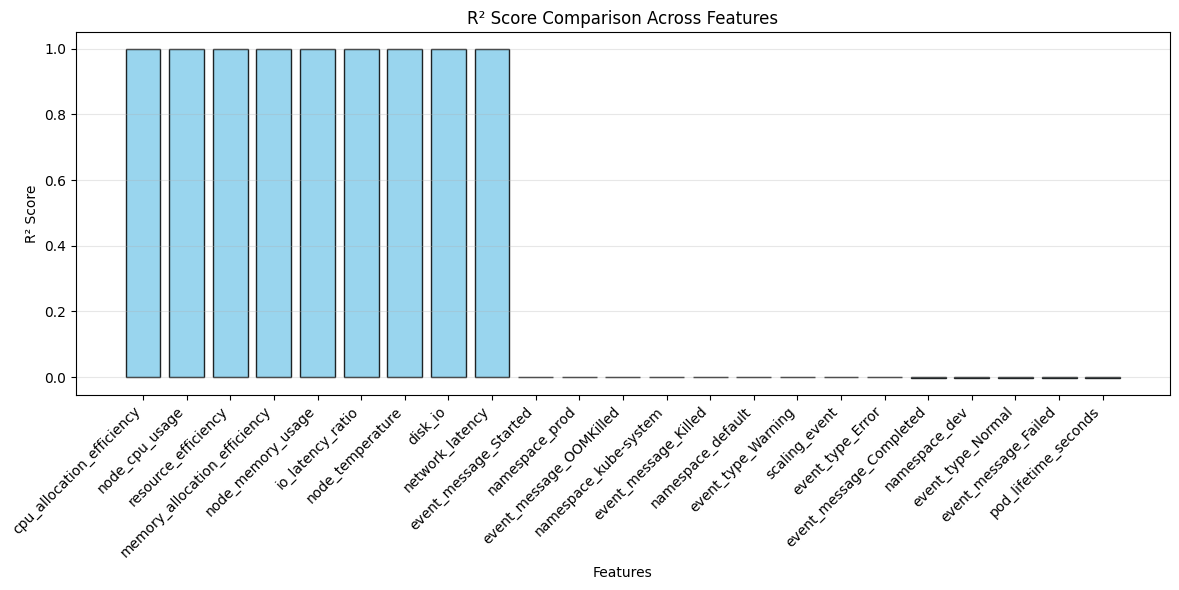

In [172]:
# Create a DataFrame for results
r2_results = pd.DataFrame({"Feature": columns_to_compare, "R² Score": r2_scores})

# Sort by R² Score
r2_results = r2_results.sort_values(by="R² Score", ascending=False)

# Plot the R² scores as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    r2_results["Feature"],
    r2_results["R² Score"],
    color="skyblue",
    edgecolor="black",
    alpha=0.85,
)
plt.title("R² Score Comparison Across Features")
plt.xlabel("Features")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2. Applying Random Forest Regressor for Multiple Columns

In this step, we’ll use **Random Forest Regressor** to predict multiple target columns in the dataset. For each column in `columns_to_compare`, we:

1. Treat the column as the target variable.
2. Train a **Random Forest Regressor** using the numerical features as inputs.
3. Evaluate the model’s performance using:
   - **R² Score**: Measures how well the model predicts the target. Higher scores are better.
   - **Mean Absolute Error (MAE)**: Shows the average difference between predicted and actual values.
   - **Scatter Plots**: Show how close the predicted values are to the actual values.

#### How to Read the Scatter Plots

- **Close to the Red Dashed Line**: Indicates accurate predictions.
- **Far from the Red Dashed Line**: Suggests the model struggles to predict that target.

Let’s apply Random Forest to each target and visualize the results!

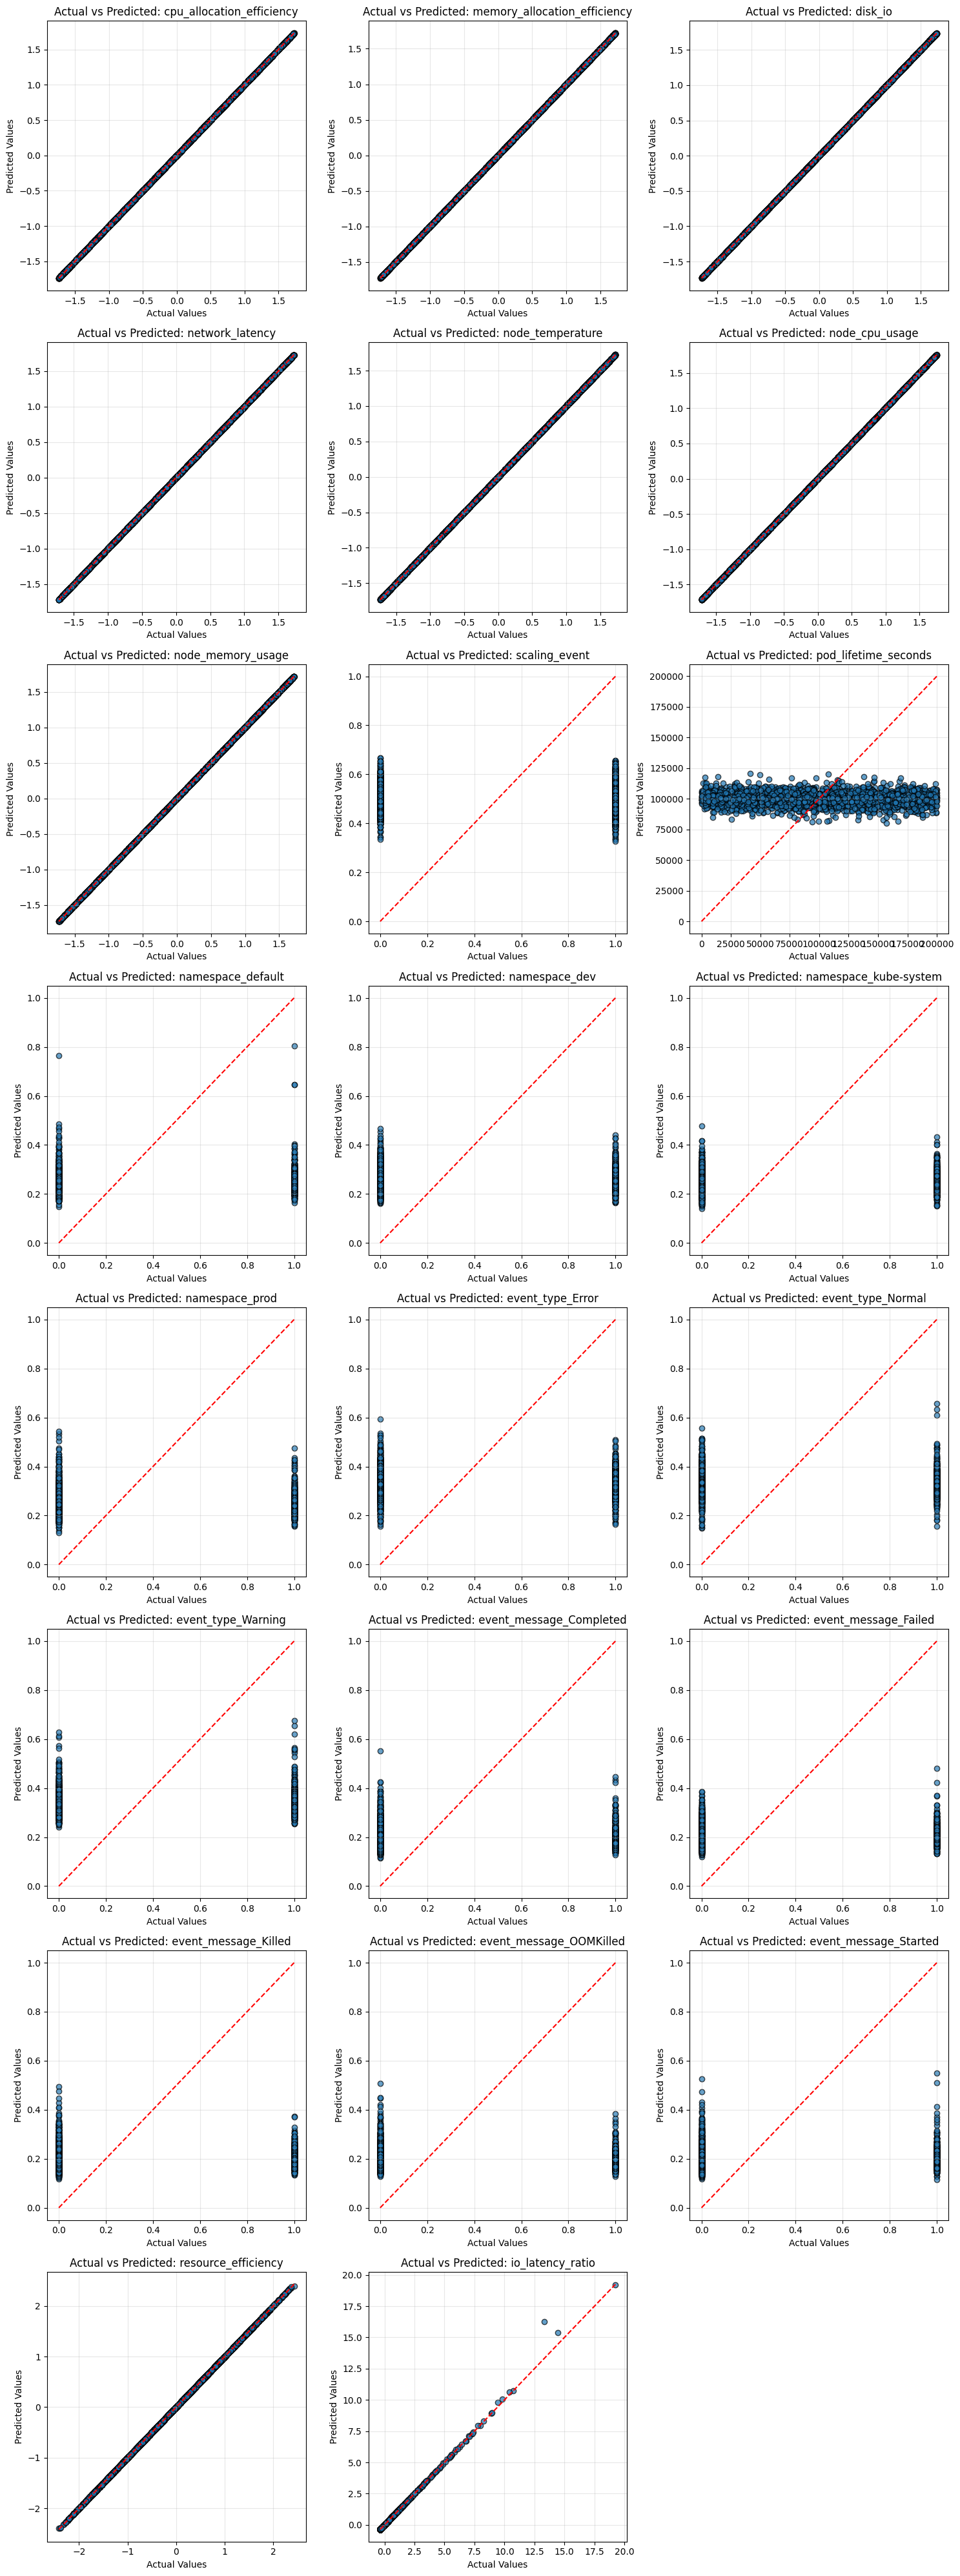

In [173]:
from sklearn.ensemble import RandomForestRegressor

# Prepare subplots
n_cols = 3  # Number of columns for subplots
n_rows = (len(columns_to_compare) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Store R² scores
rf_r2_scores = []
rf_mae_scores = []

# Loop through each feature and create Actual vs Predicted chart
for idx, feature in enumerate(columns_to_compare):
    # Define target and features
    target = feature
    X = df[numerical_features]  # Using all numerical features as predictors
    y = df[target]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Train Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    rf_r2_scores.append(r2)

    # MAE Score
    mae = mean_absolute_error(y_test, y_pred)
    rf_mae_scores.append(mae)

    # Plot Actual vs Predicted
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    ax.set_title(f"Actual vs Predicted: {feature}")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(alpha=0.3)

# Remove empty subplots (if any)
for idx in range(len(columns_to_compare), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

### Visualizing R² Scores Across Features

After applying **Random Forest** to multiple target columns, we summarize the results with an R² score comparison.

#### What Does the Chart Show?

- The bar chart ranks each feature based on its **R² score**.
- **R² Score**:
  - Measures how well the Random Forest model explains the variability of the target.
  - Higher scores indicate better predictions for that feature.
  - Lower scores suggest the model struggles to capture the relationship.

#### How to Read the Chart

- Taller bars: The model performs well for these features.
- Shorter bars: These features may need more complex models or additional preprocessing.

This visualization helps identify which features are better suited for Random Forest and where alternative methods might be needed.

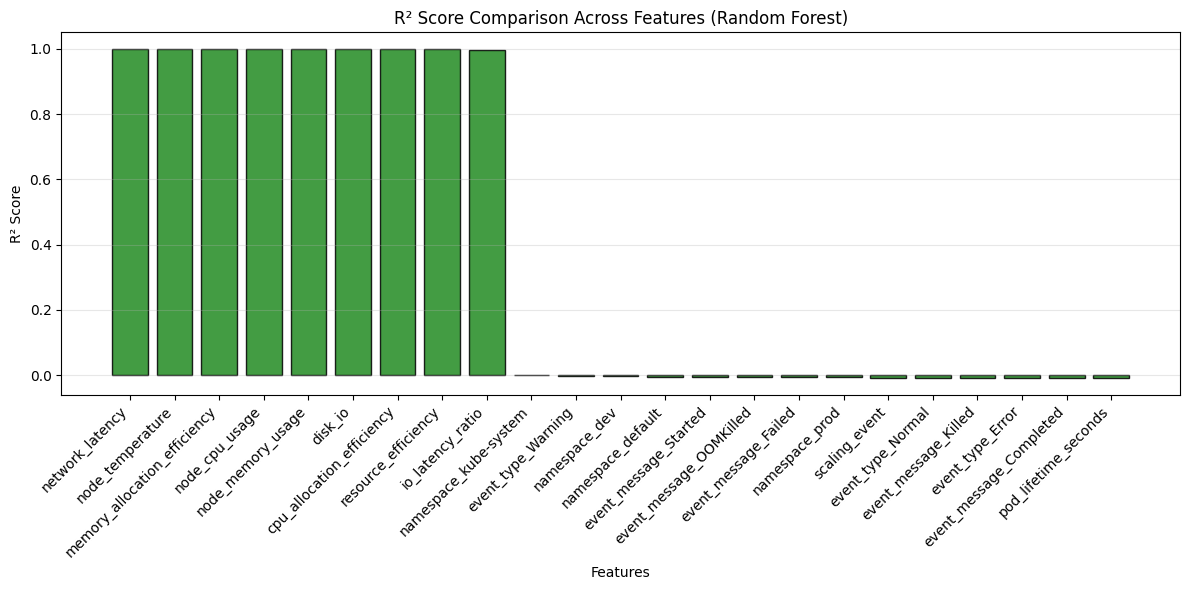

In [174]:
# Create a DataFrame for results
rf_r2_results = pd.DataFrame({"Feature": columns_to_compare, "R² Score": rf_r2_scores})

# Sort by R² Score
rf_r2_results = rf_r2_results.sort_values(by="R² Score", ascending=False)

# Plot the R² scores for Random Forest as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    rf_r2_results["Feature"],
    rf_r2_results["R² Score"],
    color="forestgreen",
    edgecolor="black",
    alpha=0.85,
)
plt.title("R² Score Comparison Across Features (Random Forest)")
plt.xlabel("Features")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Comparing R² Scores: Linear Regression vs. Random Forest

After evaluating both **Linear Regression** and **Random Forest Regressor** for multiple target columns, let’s compare their **R² scores** for each target. This comparison will help us identify:
- Which method performs better for specific features.
- The overall effectiveness of each model across all targets.

### Steps for Comparison

1. **Combine Results**:
   - Create a DataFrame that contains the R² scores for each method (`Linear Regression` and `Random Forest`) across all target columns.

2. **Bar Chart Visualization**:
   - Plot a grouped bar chart:
     - **X-axis**: Target columns (`columns_to_compare`).
     - **Y-axis**: R² scores.
     - Two bars for each target: one for `Linear Regression` and one for `Random Forest`.

3. **Interpretation**:
   - Higher bars indicate better performance.
   - Compare which model performs better for each target.

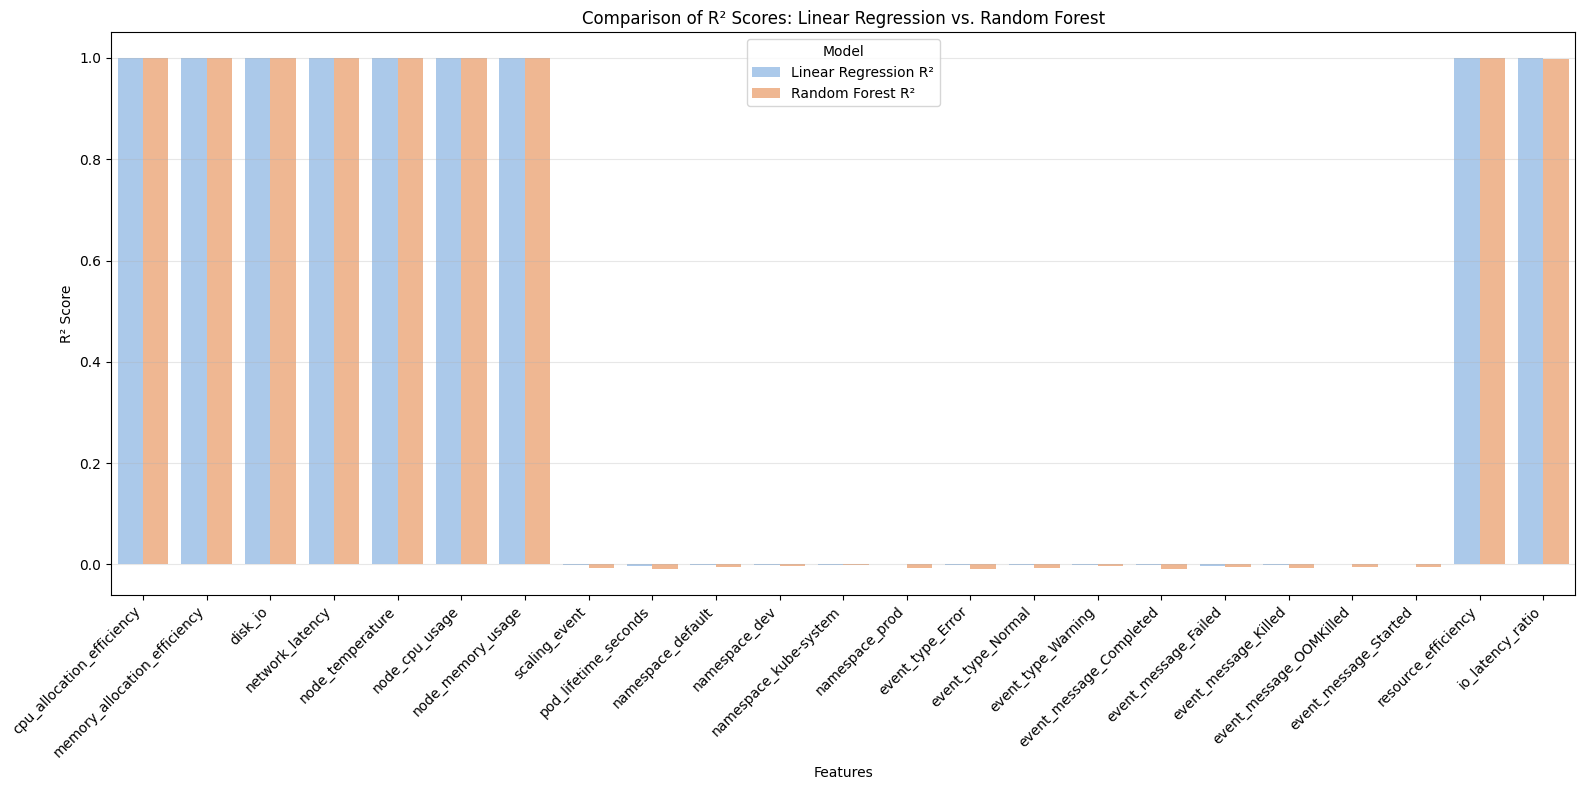

In [176]:
# Combine R² results into a DataFrame
comparison_df = pd.DataFrame(
    {
        "Feature": columns_to_compare,
        "Linear Regression R²": r2_scores,
        "Random Forest R²": rf_r2_scores,
    }
)

# Melt the DataFrame for easier plotting
comparison_melted = comparison_df.melt(
    id_vars="Feature",
    value_vars=["Linear Regression R²", "Random Forest R²"],
    var_name="Model",
    value_name="R² Score",
)

# Plot the grouped bar chart
plt.figure(figsize=(16, 8))
sns.barplot(
    x="Feature", y="R² Score", hue="Model", data=comparison_melted, palette="pastel"
)
plt.title("Comparison of R² Scores: Linear Regression vs. Random Forest")
plt.xlabel("Features")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#### How to Interpret the Chart

1. **Model Performance**:
   - For each feature, compare the heights of the two bars.
   - Taller bars indicate better performance for that model on the feature.

2. **Feature-Specific Trends**:
   - Identify features where `Random Forest` significantly outperforms `Linear Regression`.
   - Look for features where both models perform poorly (low R² scores), which might indicate the need for feature engineering or a different modeling approach.

3. **Overall Trends**:
   - Assess which model is generally better across all features.

### 8. Conclusion

In this notebook, we explored and applied two machine learning models—**Linear Regression** and **Random Forest Regressor**—to predict multiple target columns in a Kubernetes operational dataset. Here’s a summary of what we achieved:

### What We Did

1. **Preprocessing and Scaling**:
   - Standardized numerical features to ensure consistent input ranges for all models.

2. **Linear Regression**:
   - Predicted multiple continuous target variables and evaluated performance using **R² Score** and **Mean Absolute Error (MAE)**.
   - Visualized **Actual vs. Predicted** values for each target.

3. **Random Forest Regressor**:
   - Applied Random Forest to the same targets to capture non-linear relationships and compare performance with Linear Regression.
   - Evaluated results using **R² Score** and **MAE**.
   - Identified key features contributing to predictions using **Feature Importance**.

4. **Model Comparison**:
   - Compared the R² scores for both methods across all target variables using a grouped bar chart.
   - Highlighted cases where Random Forest outperformed Linear Regression and vice versa.

### Key Insights

- **Model Strengths**:
  - **Linear Regression** performed well for targets with simpler, linear relationships (e.g., `resource_efficiency`).
  - **Random Forest** excelled in capturing complex, non-linear patterns in the data.
  
- **Feature Importance**:
  - Metrics like `cpu_allocation_efficiency`, `network_latency`, and `memory_allocation_efficiency` were consistently important predictors for many targets.

- **Performance Gaps**:
  - Some features had low R² scores for both models, suggesting a need for additional feature engineering or alternative modeling approaches.

### Next Steps

In the next notebook, we will:
1. Transition from supervised learning to **unsupervised learning**, focusing on detecting anomalies without labeled data.
2. Apply clustering techniques like **K-Means** to uncover hidden patterns and outliers in Kubernetes metrics.
3. Use dynamic visualizations to explore clusters and identify operational risks.